### Topic Evolution across Years and Comparing Topics in Fiction and Diaries


In [1]:
'''
Load config and core paths for interpretation notebook
'''
from config import (
    METADATA_PATH,
    CSV_DIR,
    VISUALS_DIR,
    NUM_TOPICS
)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")

Loaded config. Output folders exist already or are created.


In [2]:
'''
Aggregate topic weights by year
>>> metadata is separated with ;
'''

# loading topic distributions and metadata
doc_topics = pd.read_csv(CSV_DIR / "document_topic_distributions.csv", index_col=0)
metadata = pd.read_csv(METADATA_PATH, sep=";")

# merging metadata with topic distributions using filename as key
merged = metadata.merge(doc_topics, left_on="filename", right_index=True)

# grouping by year and calculating average topic weight per year
topic_by_year = merged.groupby("year")[doc_topics.columns].mean()

topic_by_year.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
year,,,,,,,,,,
1910,0.000400,0.000400,0.000400,0.000400,0.000400,0.680532,0.000400,0.023148,0.267679,0.026239
1911,0.093221,0.063642,0.043900,0.012373,0.041303,0.576405,0.000555,0.055770,0.109191,0.003640
1912,0.097991,0.131280,0.032204,0.002751,0.262695,0.299543,0.002446,0.070859,0.047856,0.052375
1913,0.026107,0.047042,0.011243,0.061586,0.026941,0.084899,0.020976,0.471919,0.142116,0.107171
1914,0.020146,0.091459,0.069281,0.078662,0.054259,0.078756,0.008932,0.283585,0.081408,0.233513


### 1: Evolution of Topics Across Years

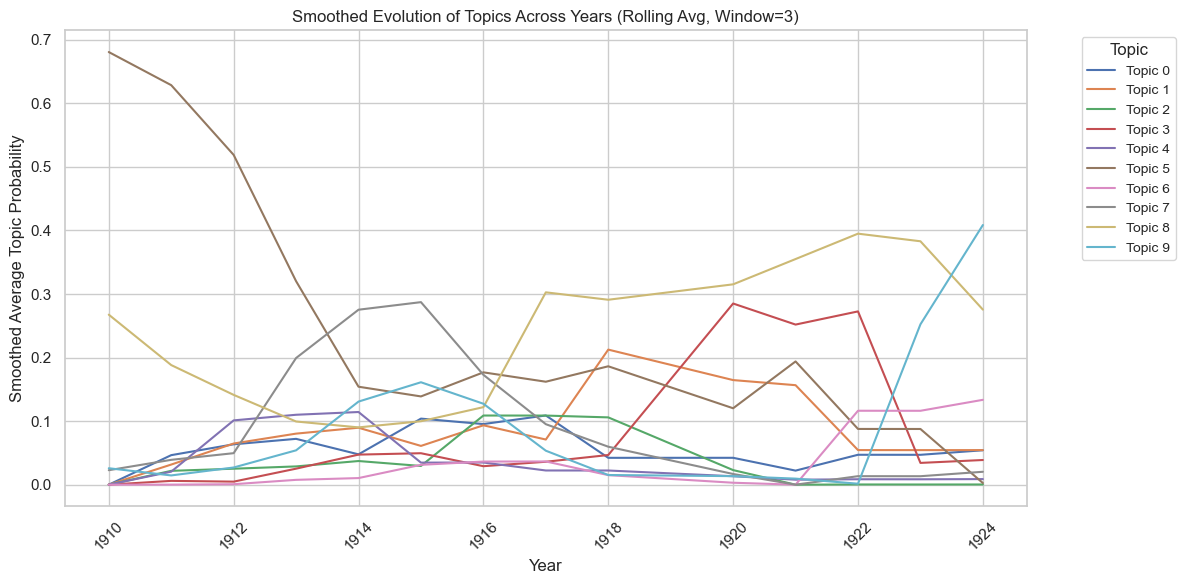

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from config import CSV_DIR, METADATA_PATH, VISUALS_DIR

metadata = pd.read_csv(METADATA_PATH, sep=";")
doc_topics = pd.read_csv(CSV_DIR / "document_topic_distributions.csv", index_col=0)

merged = metadata.merge(doc_topics, left_on="filename", right_index=True)

topic_by_year = merged.groupby("year")[doc_topics.columns].mean()

# rolling average --> can change window size (3 is best)
topic_by_year_smooth = topic_by_year.rolling(window=3, min_periods=1).mean()
'''
# can also apply gaussian rolling average like here (a bit smoother):

topic_by_year_smooth = topic_by_year.rolling(window=5, win_type='gaussian', min_periods=1).mean(std=1.0)

'''

# Plot
plt.figure(figsize=(12, 6))
for column in topic_by_year_smooth.columns:
    plt.plot(topic_by_year_smooth.index, topic_by_year_smooth[column], label=column)

plt.title("Smoothed Evolution of Topics Across Years (Rolling Avg, Window=3)")
plt.xlabel("Year")
plt.ylabel("Smoothed Average Topic Probability")
plt.xticks(rotation=45)
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.savefig(VISUALS_DIR / "topic_evolution_smoothed.png")
plt.show()

### 2: Evolution of Topics by Type (Fiction vs. Diaries)

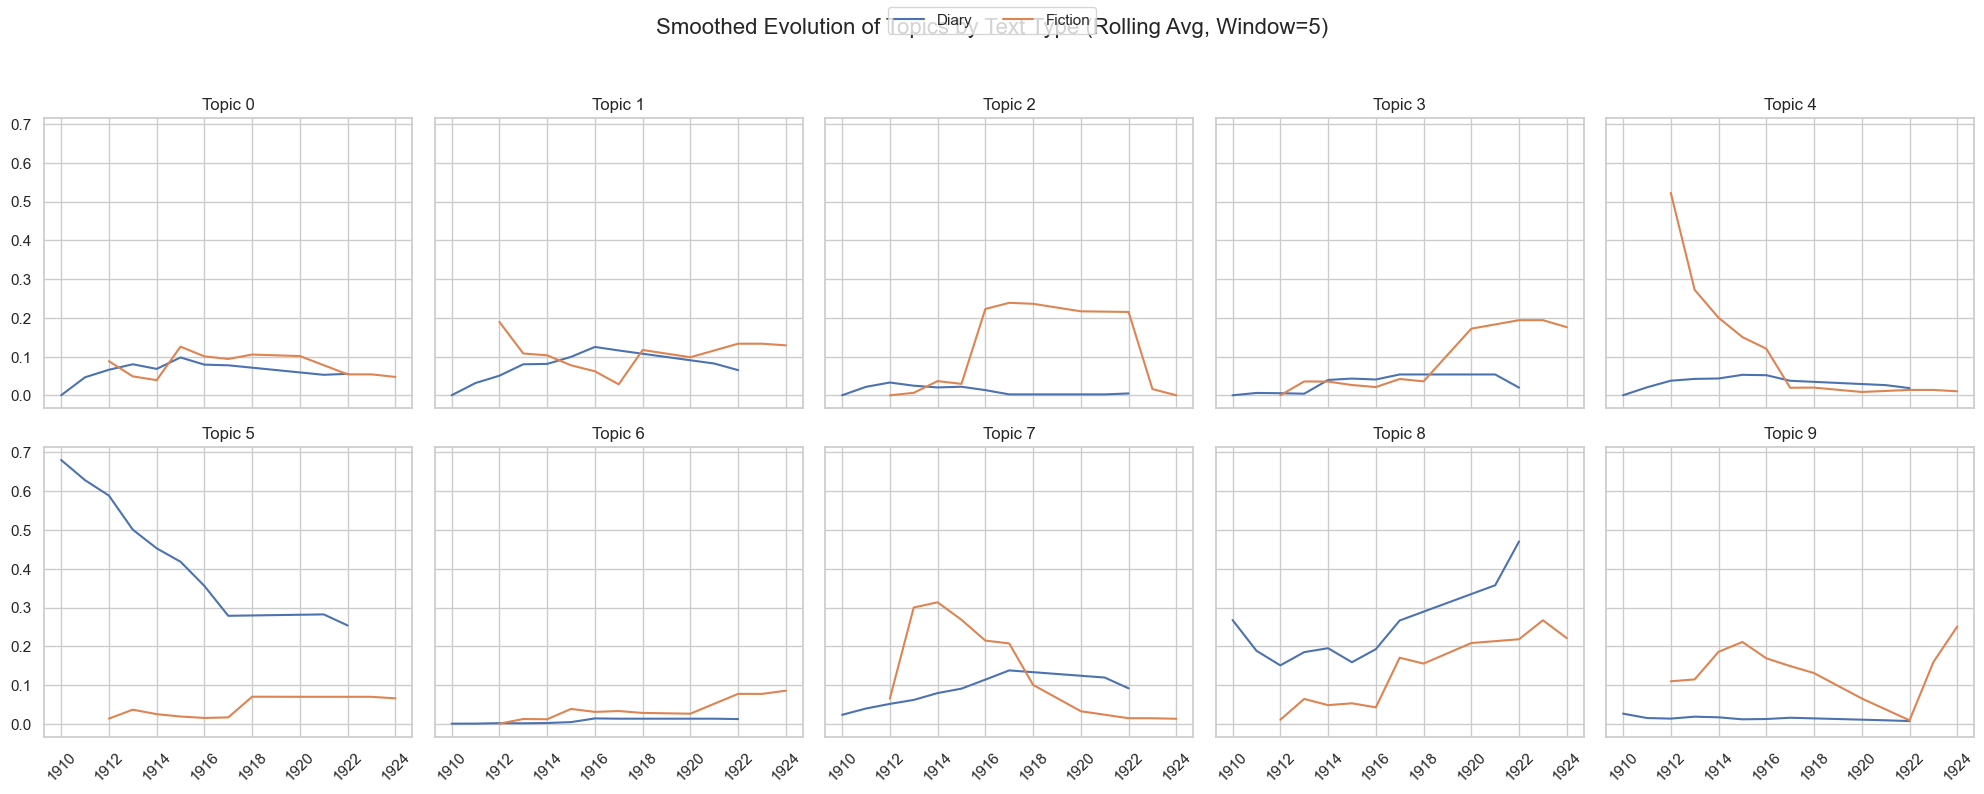

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from config import CSV_DIR, METADATA_PATH, VISUALS_DIR

metadata = pd.read_csv(METADATA_PATH, sep=";")
doc_topics = pd.read_csv(CSV_DIR / "document_topic_distributions.csv", index_col=0)

merged = metadata.merge(doc_topics, left_on="filename", right_index=True)

# grouping year and type
topic_by_year_type = (
    merged.groupby(["year", "type"])[doc_topics.columns]
    .mean()
    .reset_index()
)

# creating subplots: 2 rows and 5 columns (for 10 topics)
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

for idx, topic in enumerate(doc_topics.columns):
    ax = axes[idx]

    for text_type in topic_by_year_type["type"].unique():
        subset = topic_by_year_type[topic_by_year_type["type"] == text_type].sort_values("year")
        smoothed = subset.set_index("year")[topic].rolling(window=5, min_periods=1).mean()
        ax.plot(subset["year"], smoothed, label=f"{text_type.title()}")

    ax.set_title(f"{topic}")
    ax.tick_params(axis='x', rotation=45)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)
fig.suptitle("Smoothed Evolution of Topics by Text Type (Rolling Avg, Window=5)", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(VISUALS_DIR / "topics_smoothed_by_type_combined.png")
plt.show()